In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the pickle file
file_path = "/Users/IrisW/Documents/0Macaskill/AST_data/AM_GH3_4_merged_data.pkl"  # Update this path as needed
with open(file_path, "rb") as file:
    data = pickle.load(file)
# Ensure the data is a DataFrame
if not isinstance(data, pd.DataFrame):
    raise ValueError("The loaded data is not a Pandas DataFrame.")

/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_9873/878330982.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trial_counts = data.groupby(["session", "animal"]).size().reset_index(name="total_trials")


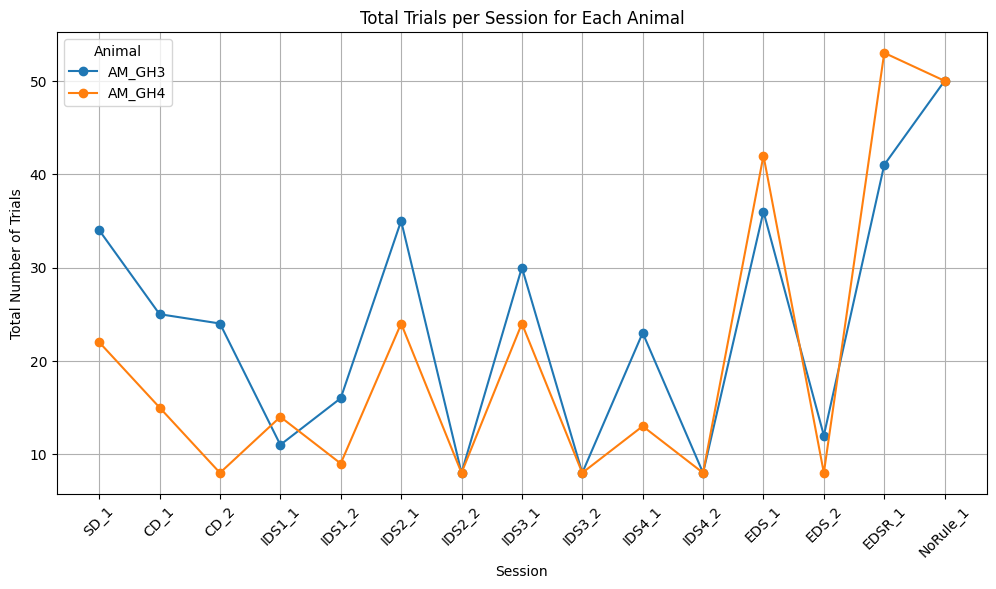

In [4]:
# plot two animals all the session together, line-point graph.
# Count the number of trials per session for each animal
trial_counts = data.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Pivot the data for plotting
pivot_data = trial_counts.pivot(index="session", columns="animal", values="total_trials")

# Plot the line-point graph
plt.figure(figsize=(12, 6))
for animal in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[animal], marker="o", label=animal)

plt.xlabel("Session")
plt.ylabel("Total Number of Trials")
plt.title("Total Trials per Session for Each Animal")
plt.xticks(rotation=45)
plt.legend(title="Animal")
plt.grid(True)
plt.show()

/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_9873/3161336294.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trial_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")


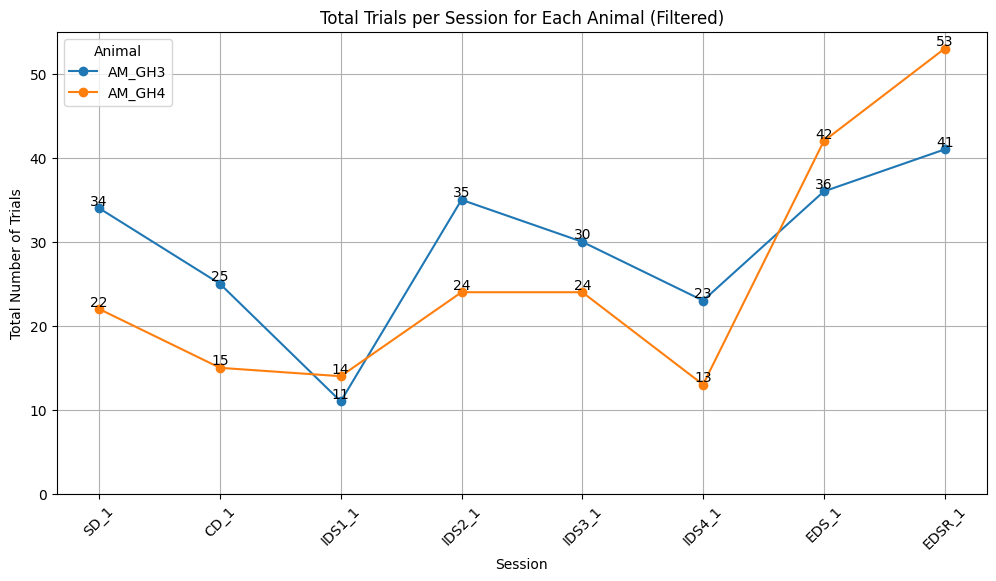

In [10]:
### show only "_1" sessions and exclude "NoRule_1" session.
# # Filter sessions: Exclude 'NoRule_1' and include only sessions ending with '_1'
data_filtered = data[(data["session"] != "NoRule_1") & (data["session"].str.endswith("_1"))].copy()

# Count the number of trials per session for each animal
trial_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Explicitly filter trial_counts again to ensure only correct sessions are included
trial_counts = trial_counts[trial_counts["session"].isin(data_filtered["session"].unique())]

# Pivot the data for plotting
pivot_data = trial_counts.pivot(index="session", columns="animal", values="total_trials")

# Plot the line-point graph
plt.figure(figsize=(12, 6))
for animal in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[animal], marker="o", label=animal)
    # (optional) Add data labels of each point
    for x, y in zip(pivot_data.index, pivot_data[animal]):
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10)
plt.xlabel("Session")
plt.ylabel("Total Number of Trials")
plt.title("Total Trials per Session for Each Animal (Filtered)")
plt.xticks(rotation=45)
plt.ylim(0, 55)  # Set y-axis limits from 0 to 55
plt.legend(title="Animal")
plt.grid(True)
plt.show()

/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_9873/3674235678.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trial_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")


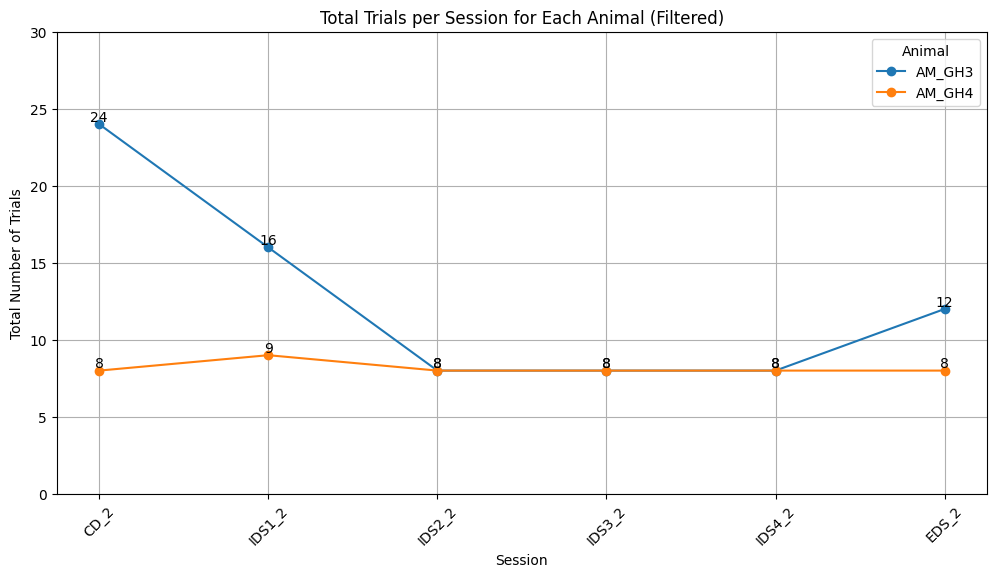

In [12]:
### show only "_2" sessions and exclude "NoRule_1" session.
# # Filter sessions: Exclude 'NoRule_1' and include only sessions ending with '_1'
data_filtered = data[(data["session"] != "NoRule_1") & (data["session"].str.endswith("_2"))].copy()

# Count the number of trials per session for each animal
trial_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Explicitly filter trial_counts again to ensure only correct sessions are included
trial_counts = trial_counts[trial_counts["session"].isin(data_filtered["session"].unique())]

# Pivot the data for plotting
pivot_data = trial_counts.pivot(index="session", columns="animal", values="total_trials")

# Plot the line-point graph
plt.figure(figsize=(12, 6))
for animal in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[animal], marker="o", label=animal)
    # (optional) Add data labels of each point
    for x, y in zip(pivot_data.index, pivot_data[animal]):
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10)
plt.xlabel("Session")
plt.ylabel("Total Number of Trials")
plt.title("Total Trials per Session for Each Animal (Filtered)")
plt.xticks(rotation=45)
plt.ylim(0, 30)  # Set y-axis limits from 0 to 55
plt.legend(title="Animal")
plt.grid(True)
plt.show()

/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_9873/2328217149.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incorrect_counts = data_filtered[data_filtered["correct"] == 0].groupby(["session", "animal"]).size().reset_index(name="incorrect_trials")


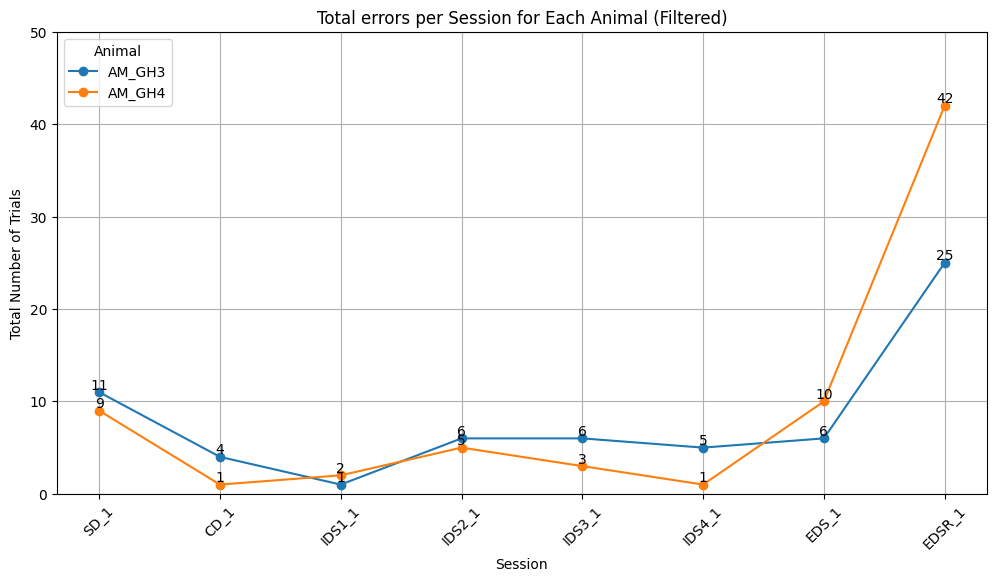

In [26]:
import numpy as np
# Count the number of incorrect (correct == 0) trials per session for each animal
# # Filter sessions: Exclude 'NoRule_1' and include only sessions ending with '_1'
data_filtered = data[(data["session"] != "NoRule_1") & (data["session"].str.endswith("_1"))].copy()
incorrect_counts = data_filtered[data_filtered["correct"] == 0].groupby(["session", "animal"]).size().reset_index(name="incorrect_trials")
# Explicitly filter trial_counts again to ensure only correct sessions are included
incorrect_counts = incorrect_counts[incorrect_counts["session"].isin(data_filtered["session"].unique())]
# Pivot the data for plotting
pivot_data = incorrect_counts.pivot(index="session", columns="animal", values="incorrect_trials")

# Plot the bar chart
plt.figure(figsize=(12, 6))
for animal in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[animal], marker="o", label=animal)
    # (optional) Add data labels of each point
    for x, y in zip(pivot_data.index, pivot_data[animal]):
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10)
plt.xlabel("Session")
plt.ylabel("Total Number of Trials")
plt.title("Total errors per Session for Each Animal (Filtered)")
plt.xticks(rotation=45)
plt.ylim(0, 50)  # Set y-axis limits from 0 to 55
plt.legend(title="Animal")
plt.grid(True)
plt.show()

/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_14885/2858749045.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")
/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_14885/2858749045.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incorrect_counts = data_filtered[data_filtered["correct"] == 0].groupby(["session", "animal"]).size().reset_index(name="incorrect_trials")
/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_14885/2858749045.py:20: DeprecationWarning: is_categorical_dt

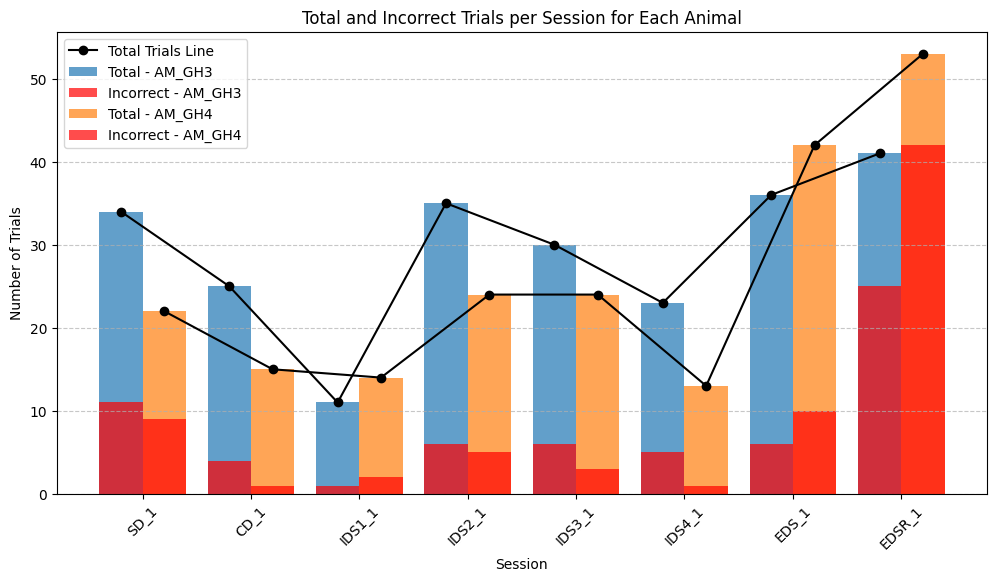

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter sessions: Include only sessions that explicitly end with '_1' and exclude "NoRule_1"
data_filtered = data[(data["session"].str.endswith("_1")) & (data["session"] != "NoRule_1")].copy()

# Count the number of total trials per session for each animal
total_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Count the number of incorrect (correct == 0) trials per session for each animal
incorrect_counts = data_filtered[data_filtered["correct"] == 0].groupby(["session", "animal"]).size().reset_index(name="incorrect_trials")

# Ensure that both total_counts and incorrect_counts only include filtered sessions
total_counts = total_counts[total_counts["session"].isin(data_filtered["session"].unique())]
incorrect_counts = incorrect_counts[incorrect_counts["session"].isin(data_filtered["session"].unique())]

# Convert categorical columns to string
for col in ["session", "animal"]:
    if col in total_counts and pd.api.types.is_categorical_dtype(total_counts[col]):
        total_counts[col] = total_counts[col].astype(str)
    if col in incorrect_counts and pd.api.types.is_categorical_dtype(incorrect_counts[col]):
        incorrect_counts[col] = incorrect_counts[col].astype(str)

# Merge the two dataframes
merged_counts = pd.merge(total_counts, incorrect_counts, on=["session", "animal"], how="left").fillna(0)

# Re-filter merged_counts after merging
merged_counts = merged_counts[merged_counts["session"].isin(data_filtered["session"].unique())]

# Define the desired session order
session_order = ["SD_1", "CD_1", "IDS1_1", "IDS2_1", "IDS3_1", "IDS4_1", "EDS_1", "EDSR_1"]
# Sort data by session order
merged_counts["session"] = pd.Categorical(merged_counts["session"], categories=session_order, ordered=True)
merged_counts = merged_counts.sort_values("session")

# Pivot data for plotting
total_pivot = merged_counts.pivot(index="session", columns="animal", values="total_trials")
incorrect_pivot = merged_counts.pivot(index="session", columns="animal", values="incorrect_trials")

# Plot the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.4  # Width of bars
x = np.arange(len(total_pivot.index))  # X locations for the groups

# Plot total trials as bars
for i, animal in enumerate(total_pivot.columns):
    ax1.bar(x + i * bar_width, total_pivot[animal], width=bar_width, label=f"Total - {animal}", alpha=0.7)
    ax1.bar(x + i * bar_width, incorrect_pivot[animal], width=bar_width, label=f"Incorrect - {animal}", alpha=0.7, color='red')
    # Find the middle of the total trials bar and plot the point
    middle_x = x + i * bar_width
    top_y = total_pivot[animal]
    ax1.plot(middle_x, top_y, marker="o", linestyle="-", color="black", label="" if i > 0 else "Total Trials Line")

ax1.set_xlabel("Session")
ax1.set_ylabel("Number of Trials")
ax1.set_title("Total and Incorrect Trials per Session for Each Animal")
ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(total_pivot.index, rotation=45)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_14885/1685680763.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")
/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_14885/1685680763.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incorrect_counts = data_filtered[data_filtered["correct"] == 0].groupby(["session", "animal"]).size().reset_index(name="incorrect_trials")
/var/folders/_c/spn0z31n35b5kdx72n0x01gm0000gn/T/ipykernel_14885/1685680763.py:20: DeprecationWarning: is_categorical_dt

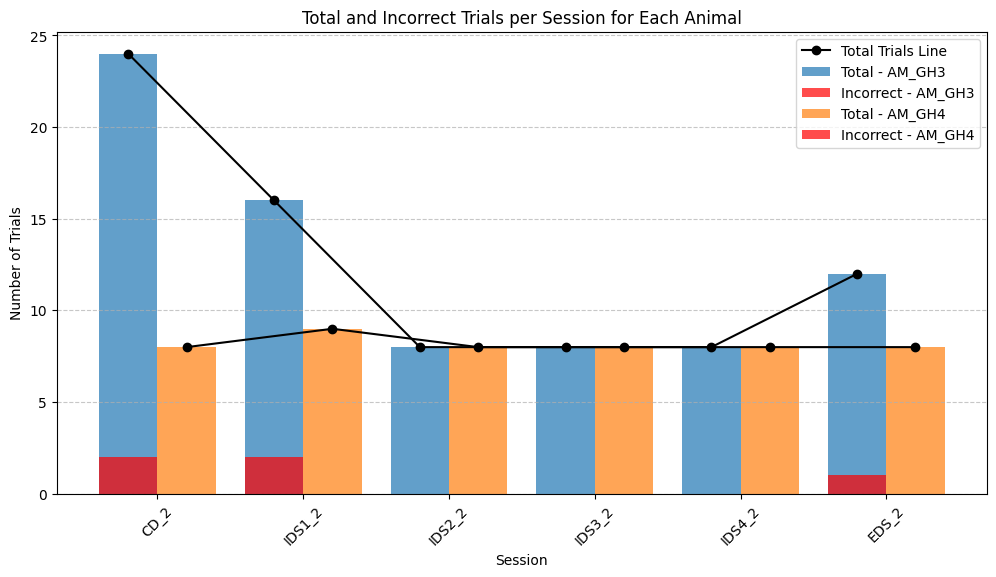

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter sessions: Include only sessions that explicitly end with '_1' and exclude "NoRule_1"
data_filtered = data[(data["session"].str.endswith("_2")) & (data["session"] != "NoRule_1")].copy()

# Count the number of total trials per session for each animal
total_counts = data_filtered.groupby(["session", "animal"]).size().reset_index(name="total_trials")

# Count the number of incorrect (correct == 0) trials per session for each animal
incorrect_counts = data_filtered[data_filtered["correct"] == 0].groupby(["session", "animal"]).size().reset_index(name="incorrect_trials")

# Ensure that both total_counts and incorrect_counts only include filtered sessions
total_counts = total_counts[total_counts["session"].isin(data_filtered["session"].unique())]
incorrect_counts = incorrect_counts[incorrect_counts["session"].isin(data_filtered["session"].unique())]

# Convert categorical columns to string
for col in ["session", "animal"]:
    if col in total_counts and pd.api.types.is_categorical_dtype(total_counts[col]):
        total_counts[col] = total_counts[col].astype(str)
    if col in incorrect_counts and pd.api.types.is_categorical_dtype(incorrect_counts[col]):
        incorrect_counts[col] = incorrect_counts[col].astype(str)

# Merge the two dataframes
merged_counts = pd.merge(total_counts, incorrect_counts, on=["session", "animal"], how="left").fillna(0)

# Re-filter merged_counts after merging
merged_counts = merged_counts[merged_counts["session"].isin(data_filtered["session"].unique())]

# Define the desired session order
session_order = ["CD_2", "IDS1_2", "IDS2_2", "IDS3_2", "IDS4_2", "EDS_2"]
# Sort data by session order
merged_counts["session"] = pd.Categorical(merged_counts["session"], categories=session_order, ordered=True)
merged_counts = merged_counts.sort_values("session")

# Pivot data for plotting
total_pivot = merged_counts.pivot(index="session", columns="animal", values="total_trials")
incorrect_pivot = merged_counts.pivot(index="session", columns="animal", values="incorrect_trials")

# Plot the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.4  # Width of bars
x = np.arange(len(total_pivot.index))  # X locations for the groups

# Plot total trials as bars
for i, animal in enumerate(total_pivot.columns):
    ax1.bar(x + i * bar_width, total_pivot[animal], width=bar_width, label=f"Total - {animal}", alpha=0.7)
    ax1.bar(x + i * bar_width, incorrect_pivot[animal], width=bar_width, label=f"Incorrect - {animal}", alpha=0.7, color='red')
    # Find the middle of the total trials bar and plot the point
    middle_x = x + i * bar_width
    top_y = total_pivot[animal]
    ax1.plot(middle_x, top_y, marker="o", linestyle="-", color="black", label="" if i > 0 else "Total Trials Line")

ax1.set_xlabel("Session")
ax1.set_ylabel("Number of Trials")
ax1.set_title("Total and Incorrect Trials per Session for Each Animal")
ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(total_pivot.index, rotation=45)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
